<a href="https://colab.research.google.com/github/Allamsetti-Tulasi/AI-/blob/main/translationproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import string
import re
from numpy import array,argmax,random,take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth',200) 

In [7]:
#function  to read raw textfile
def read_text(filename):
  #open file
  file=open(filename, mode='rt', encoding='utf-8')
  #read all text
  text=file.read()
  file.close()
  return text

In [8]:
#split a text into sentences
def to_lines(text):
  sents= text.strip().split('\n')
  sents= [i.split('\t') for i in sents]
  return sents

In [9]:
data = read_text("/content/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
deu_eng =  deu_eng[: 50000]

In [12]:
#lets take a look at ourr dta
deu_eng

array([list(['Go.', 'Geh.', 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)']),
       list(['Hi.', 'Hallo!', 'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)']),
       list(['Hi.', 'GrÃ¼ÃŸ Gott!', 'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)']),
       ...,
       list(["I'll stay here.", 'Ich bleibe hier.', 'CC-BY 2.0 (France) Attribution: tatoeba.org #2247811 (CK) & #2552506 (Pfirsichbaeumchen)']),
       list(["I'll stay home.", 'Ich werde zuhause bleiben.', 'CC-BY 2.0 (France) Attribution: tatoeba.org #321732 (CK) & #411159 (MUIRIEL)']),
       list(["I'll t"])], dtype=object)

In [41]:
#empty lists
eng_l=[]
deu_l=[]
#populate the lists with sentence lengths
for i in deu_eng[:]:
  eng_l.append(len(i.split()))
for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))


AttributeError: ignored

In [34]:
length_df=pd.DataFrame({'eng':eng_l,'deu':deu_l})

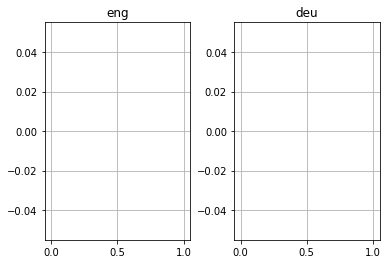

In [35]:
length_df.hist(bins=30)
plt.show()

In [38]:
#functio to build tokenize
def tokenization(lines):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [40]:
#prepare english translation
eng_tokenizer=tokenization(deu_eng[0])
eng_vocab_size=len(eng_tokenizer.word_index)+1
eng_length=8
print('english vocabulary size:%d'%eng_vocab_size)

english vocabulary size:15


In [42]:
#prepare detuch tokenizer
deu_tokenizer=tokenization(deu_eng[1])
deu_vocab_size=len(deu_tokenizer.word_index)+1
deu_length=8
print('detuch vocan=bulary size=%d'%deu_vocab_size)

detuch vocan=bulary size=15


In [43]:
#encode and pad sequence
def encode_sequences(tokenizer, length, lines):
  #integer encode sequences
  seq=tokenizer.texts_to_sequences(lines)
  #pad sequences with 0 values
  seq=pad_sequences(seq, maxlen=length, padding='post')
  return seq
  

In [47]:
from sklearn.model_selection import train_test_split
train, test=train_test_split(deu_eng, test_size=0.2, random_state=12)

In [48]:
#preparing training data
trainX= encode_sequences(deu_tokenizer, deu_length, train[1])
trainY= encode_sequences(deu_tokenizer, eng_length,train[0])


In [49]:
#prepare validatin
testX=encode_sequences(deu_tokenizer,deu_length,test[1])
testY=encode_sequences(deu_tokenizer,eng_length,test[0])

In [50]:
#built NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps,units):
  model=Sequential()
  model.add(Embedding(in_vocab,units,input_length=in_timesteps,mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units,return_sequences=True))
  model.add(Dense(out_vocab,activation="softmax"))
  return model

In [ ]:
model =build_model(deu_vocab_size,eng_vocab_size,deu_length,eng_length,512)
rms=optimizers.rmsprop(lr=0.001)
model.compile(optimizer=rms,loss='sparse_categorical_crossentropy')

In [ ]:
filename='model.h1.24_tulasi'
checkpoint=ModelCheckpoint(filename,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
history=model.fit(trainX,trainY.reshape(trainY.shape[0],trainY.shape[1],1),
                  epochs=5,batch_size=512,
                  validation_split=0.2,
                  callbacks=[checkpoint], verbose=1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


In [ ]:
model=load_model('model.h1.24_tulasi')
preds=model.predict_classes(testX.reshape((testX.shap[0],testX.shape[1])))


In [ ]:
def get_word(n,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index==n:
return word
return None

In [ ]:
#convert preiction iinto txt
preds_text=[]
for i in preds:
  temp=[]
  for j in range(len(i)):
    t=get_word(i[j],eng_tokenizer)
    if j>0:
      if (t=get_word(i[j-1],eng_tokenizer)) or (t==None):
        temp.append('')
    else:
      temp.append(t)
      else:
        if (t==None):
          temp.append('')
          else:
            temp.append(''.join(temp))
            

In [ ]:
pred_df=pd.DataFrame({'actual':test[0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth',200)

In [ ]:
pred_df.head(15)

In [ ]:
pred_df.tail(15)